In [1]:
import json, pickle
import glob

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima, FakeBelem, FakeJakarta, FakeGuadalupe

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, random_clifford_circuit
from gnn import ExpValCircuitGraphModel
from qiskit.quantum_info import Clifford
from qiskit_aer.noise import depolarizing_error, coherent_unitary_error, NoiseModel
from noise_utils import AddNoise

from functools import partial

In [2]:
backend = FakeGuadalupe()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(backend) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

num_qubit = 6

STEPS = 10

In [3]:
from qiskit.transpiler.exceptions import TranspilerError, QiskitError
import scipy
from tqdm import tqdm

def generate_data(generating_func, save_path, J_list, run_config_n, pauli_list):
    entries = []
    # J_list = tqdm(enumerate(J_list), total=len(J_list))
    J_list = enumerate(J_list)
    for i, J in J_list:
        for meas_basis in tqdm(pauli_list):
            try:
                random_ising, random_ising_partial_meas, trans_circuit, trans_circuit_partial_meas = generating_func(J, meas_basis, STEPS)
                ideal_exp_val = get_all_z_exp_wo_shot_noise(random_ising_partial_meas)

                job_noisy = backend_noisy.run(trans_circuit_partial_meas, num_shots=10000)
                counts_noisy = job_noisy.result().get_counts()
                noisy_exp_val = cal_all_z_exp(counts_noisy)
            except QiskitError:
                continue

            graph_data = circuit_to_graph_data_json(
                circuit=trans_circuit,
                properties=properties,
                use_qubit_features=True,
                use_gate_features=True,
            )

            entry = ExpValueEntry(
                circuit_graph=graph_data,
                observable=[],
                ideal_exp_value=[ideal_exp_val],
                noisy_exp_values=[[noisy_exp_val]],
                circuit_depth=trans_circuit.depth()
            )
            to_append = entry.to_dict()
            to_append['circuit'] = trans_circuit
            to_append['meas_basis'] = meas_basis
            to_append['J'] = J
            entries.append(to_append)

    path = f"{save_path}/step_{STEPS}_q{num_qubit}.pk"
    with open(path, "wb") as f:
        pickle.dump(entries, f)

In [4]:
from qiskit.circuit import Parameter

class IsingModel:

    class Options(dict):
        def __init__(self, *args, **kwargs):
            super().__init__()
            self['nq'] = num_qubit
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4
            self['depth'] = 15
            self.update(*args, **kwargs)

        def config_4q_paper(self):
            self['h'] = 1
            self['J'] = 0.15
            self['dt'] = 1/4*2

        def config_10q_paper(self):
            self['h'] = 1
            self['J'] = 0.5236
            self['dt'] = 1/4


    @classmethod
    def apply_quantum_circuit_layer(cls, qc: QuantumCircuit, ops: 'IsingModel.Options'):
        allq = list(range(ops['nq']))

        qc.rx(2*ops['h']*ops['dt'], allq)

        qc.barrier()
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[1::2])
        for q0 in allq[0::2]:
            q1 = q0+1
            qc.cx(q0,q1)

        qc.barrier()
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.rz(-2*ops['J']*ops['dt'], allq[2:-1:2])
        for q0 in allq[1:-2:2]:
            q1 = q0+1
            qc.cx(q0,q1)
        qc.barrier()

    @classmethod
    def make_quantum_circuit(cls, ops: 'IsingModel.Options'):
        qregs = QuantumRegister(ops['nq'])
        qc = QuantumCircuit(qregs)

        for step in range(ops['depth']):
            cls.apply_quantum_circuit_layer(qc, ops)

        for i, pauli in enumerate(ops['measure_basis']):
            if pauli in 'ZI':
                pass
            elif pauli == 'X':
                qc.h(i)
            elif pauli == 'Y':
                qc.sdg(i)
                qc.h(i)
            else:
                raise Exception("Must be X Y Z or I")
        qc.measure_all()

        return qc

    @classmethod
    def make_quantum_circuit_partial_meas(cls, ops: 'IsingModel.Options'):
        qregs = QuantumRegister(ops['nq'])
        cregs = ClassicalRegister(ops['nq'])
        qc = QuantumCircuit(qregs, cregs)

        for step in range(ops['depth']):
            cls.apply_quantum_circuit_layer(qc, ops)

        for i, pauli in enumerate(ops['measure_basis']):
            if pauli in 'Z':
                qc.measure(qregs[i], cregs[i])
            elif pauli == 'X':
                qc.h(i)
                qc.measure(qregs[i], cregs[i])
            elif pauli == 'Y':
                qc.sdg(i)
                qc.h(i)
                qc.measure(qregs[i], cregs[i])
            elif pauli == 'I':
                pass
            else:
                raise Exception("Must be X Y Z or I")

        return qc

    @classmethod
    def make_circs_sweep(cls, ops, num_steps, measure_basis):
        ops['measure_basis'] = measure_basis
        ops['depth'] = num_steps
        qc = cls.make_quantum_circuit(ops)
        qc_partial_meas = cls.make_quantum_circuit_partial_meas(ops)
        qc.metadata = {}
        qc_partial_meas.metadata = {}
        qc.metadata['measure_basis'] = measure_basis
        qc.metadata['depth'] = num_steps
        qc_partial_meas.metadata['measure_basis'] = measure_basis
        qc_partial_meas.metadata['depth'] = num_steps
        return qc, qc_partial_meas

In [5]:
# cls = IsingModel
# ops = cls.Options()
# ops.config_4q_paper()
# ops.update({'J': Parameter('J'), 'h': Parameter('h')})
# qc = cls.make_circs_sweep(ops, 1, 'XXYZ'), list(range(4))
# qc[0].draw('mpl', fold=-1)

# Random Ising Init

In [5]:
def get_measurement_qubits(qc, num_measured_qubit):
    measurement_qubits = []
    for measurement in range(num_measured_qubit - 1, -1, -1):
        measurement_qubits.append(qc.data[-1 - measurement][1][0].index)
    return measurement_qubits

{1, 3}


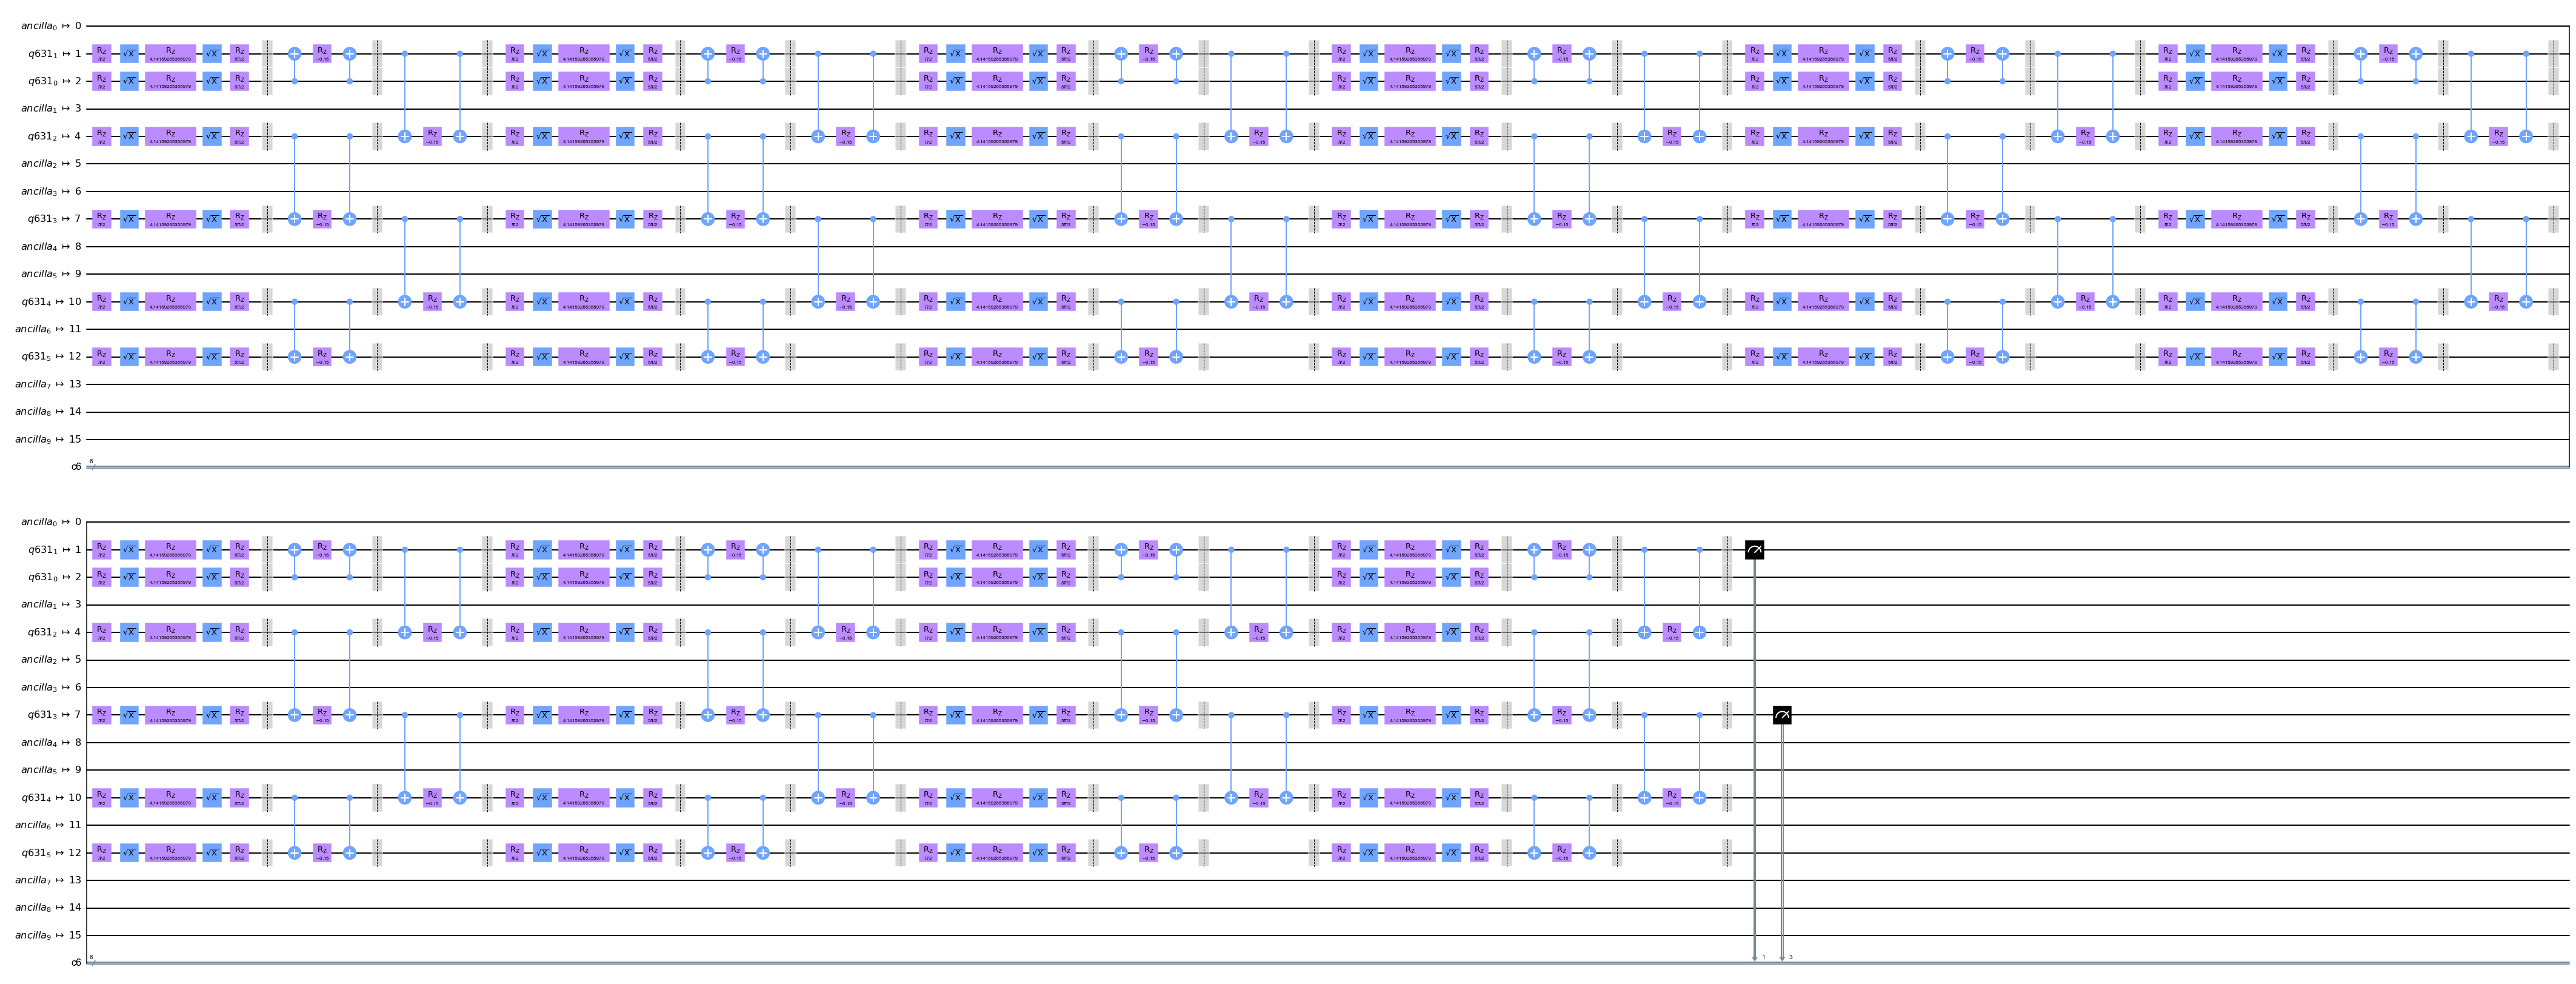

In [15]:
from qiskit.quantum_info import random_statevector
from qiskit.circuit.library import RYGate, RXGate, RZGate, CXGate
from qiskit import QuantumRegister

def construct_ising_circuit_qasm_init(J, basis, num_steps):
    cls = IsingModel
    ops = cls.Options()
    ops.config_4q_paper()
    ops.update({'J': J})
    # ops.update({'h': 0})
    # qc_init = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[4];\nrz(0.0007186381718527407) q[1];\nrz(2.4917901988569855) q[1];\nrz(3.3854853863523835) q[3];\nrx(1.2846113715328817) q[3];\ncx q[3],q[0];\nrx(4.212671608894216) q[2];\ncx q[2],q[3];\n')
    # qc_init.barrier()
    # qc = qc_init.compose(cls.make_circs_sweep(ops, num_steps, basis), list(range(4)))
    qc, qc_partial_meas = cls.make_circs_sweep(ops, num_steps, basis)
    return qc, qc_partial_meas

J = 0.15
basis = 'IZIZII' #'IZYIXI' #'IZIIII'  # non-endian
obs = np.array(list(basis))
marginal_over_pre_trans = set(range(len(obs))).difference(set(np.where(obs == 'I')[0].tolist() if 'I' in obs else None))
print(marginal_over_pre_trans)
random_ising, random_ising_partial_meas = construct_ising_circuit_qasm_init(J, basis, 10)
trans_circuit = transpile(random_ising, backend=backend_noisy, optimization_level=3, initial_layout=[2,1,4,7,10,12])
trans_circuit_partial_meas = transpile(random_ising_partial_meas, backend=backend_noisy, optimization_level=3, initial_layout=[2,1,4,7,10,12])
# We don't need to do this marginal_over post transpilation, because the count dictionary obtained from running the transpiled full measurement circuit has number of digits that is equal to the number of qubits in the circuit before transpilation. So the marginal_over indices are the same as the one pre-transpilation
# marginal_over = get_measurement_qubits(trans_circuit_partial_meas, len(marginal_over_pre_trans))
# print(marginal_over)
trans_circuit_partial_meas.draw('mpl', fold=90)

In [21]:
from qiskit.circuit import Barrier
def remove_until_barrier(qc, obs):
    circuit = qc.copy()
    circuit.remove_final_measurements()
    data = list(circuit.data)

    if (set(obs) != {'Z'}) and (set(obs) != {'Z', 'I'}):
        data.reverse()
        for ind, instruction in enumerate(data):
            if isinstance(instruction[0], Barrier):
                break
        data = data[ind:]
        data.reverse()

    new_circuit = circuit.copy()
    new_circuit.data = data

    return new_circuit

from zne import zne, ZNEStrategy
from zne.noise_amplification import *
from zne.extrapolation import *
from qiskit.primitives import BackendEstimator
from qiskit.quantum_info import SparsePauliOp
ZNEEstimator = zne(BackendEstimator)
estimator = ZNEEstimator(backend=backend_noisy)
zne_strategy = ZNEStrategy(
    noise_factors=(1,),
    noise_amplifier=LocalFoldingAmplifier(gates_to_fold=2),
    extrapolator=PolynomialExtrapolator(degree=2)
)

def get_measurement_qubits(qc, num_measured_qubit):
    measurement_qubits = []
    for measurement in range(num_measured_qubit - 1, -1, -1):
        measurement_qubits.append(qc.data[-1 - measurement][1][0].index)
    return measurement_qubits

def form_all_qubit_observable(observable, measurement_qubits, total_num_qubits):
    assert len(observable) == len(measurement_qubits)
    converted_obs = list('I' * total_num_qubits)
    print(measurement_qubits)
    for qubit, basis in zip(measurement_qubits, list(observable)):
        converted_obs[qubit] = basis
    return ''.join(converted_obs)[::-1]

circ_no_meas_circ = remove_until_barrier(trans_circuit, basis)
pad_obs = form_all_qubit_observable(basis, get_measurement_qubits(trans_circuit, 6), backend.configuration().num_qubits)
zne_job = estimator.run(circ_no_meas_circ, SparsePauliOp(pad_obs), shots=10000, zne_strategy=zne_strategy)
zne_miti = zne_job.result().values

job_noisy = backend_noisy.run(trans_circuit_partial_meas, num_shots=10000)
counts_noisy = job_noisy.result().get_counts()
noisy_exp_val = cal_all_z_exp(counts_noisy)

exp_vals = []
N = 10
for _ in tqdm(range(N)):
    job_from_counts = backend_ideal.run(trans_circuit_partial_meas, shots=10000)
    counts = job_from_counts.result().get_counts()
    counts = {key: val for key, val in sorted(counts.items())}
    exp_vals += [cal_all_z_exp(counts)]
ideal_exp_val = sum(exp_vals) / N

print(zne_miti[0], ideal_exp_val, noisy_exp_val, basis[::-1], pad_obs)

[2, 1, 4, 7, 10, 12]


100%|██████████| 10/10 [00:00<00:00, 31.53it/s]

0.103 0.31930000000000003 0.08984375 IIZIZI IIIIIIIIZIIIIIZI


In [67]:
exp_vals = []
N = 10
for _ in tqdm(range(N)):
    # job_from_counts = execute(random_ising, **run_config_ideal)
    job_from_counts = backend_ideal.run(random_ising, shots=10000)
    counts = job_from_counts.result().get_counts()
    counts = {key: val for key, val in sorted(counts.items())}
    exp_vals += [cal_all_z_exp(counts, marginal_over=marginal_over_pre_trans)]
print(sum(exp_vals) / N)

100%|██████████| 10/10 [00:00<00:00, 39.02it/s]

-0.0844


In [68]:
exp_vals = []
N = 10
for _ in tqdm(range(N)):
    # job_from_counts = execute(random_ising, **run_config_ideal)
    job_from_counts = backend_ideal.run(trans_circuit, shots=10000)
    counts = job_from_counts.result().get_counts()
    counts = {key: val for key, val in sorted(counts.items())}
    exp_vals += [cal_all_z_exp(counts, marginal_over=marginal_over_pre_trans)]
print(sum(exp_vals) / N)

100%|██████████| 10/10 [00:00<00:00, 36.25it/s]

-0.09168000000000001


In [69]:
exp_vals = []
N = 10
for _ in tqdm(range(N)):
    # job_from_counts = execute(trans_circuit_partial_meas, **run_config_ideal)
    job_from_counts = backend_ideal.run(random_ising_partial_meas, shots=10000)
    counts = job_from_counts.result().get_counts()
    counts = {key: val for key, val in sorted(counts.items())}
    exp_vals += [cal_all_z_exp(counts)]
print(sum(exp_vals) / N)

100%|██████████| 10/10 [00:00<00:00, 49.14it/s]

-0.08942


In [70]:
exp_vals = []
N = 10
for _ in tqdm(range(N)):
    # job_from_counts = execute(trans_circuit_partial_meas, **run_config_ideal)
    job_from_counts = backend_ideal.run(trans_circuit_partial_meas, shots=10000)
    counts = job_from_counts.result().get_counts()
    counts = {key: val for key, val in sorted(counts.items())}
    exp_vals += [cal_all_z_exp(counts)]
print(sum(exp_vals) / N)

100%|██████████| 10/10 [00:00<00:00, 46.30it/s]

-0.08986


In [80]:
from qiskit.result import marginal_counts
def get_all_z_exp_wo_shot_noise(circuit, marginal_over=None):
    circuit_copy = circuit.copy()
    circuit_copy.remove_final_measurements()
    circuit_copy.save_density_matrix()

    def int_to_bin(n, num_bits):
        if n < 2**num_bits:
            binary_str = bin(n)[2:]
            return binary_str.zfill(num_bits)
        else:
            raise ValueError

    job = QasmSimulator().run(circuit_copy, backend_options={'method': 'statevector'})
    probs = np.real(np.diag(job.result().data()['density_matrix']))
    probs = {int_to_bin(i, num_bits=num_qubit): p for i, p in enumerate(probs)}

    if marginal_over:
        probs = marginal_counts(probs, indices=marginal_over)

    exp_val = 0
    for key, prob in probs.items():
        num_ones = key.count('1')
        exp_val += ((-1) ** num_ones) * prob

    return exp_val

print(get_all_z_exp_wo_shot_noise(random_ising, marginal_over=marginal_over_pre_trans))
print(get_all_z_exp_wo_shot_noise(random_ising_partial_meas))

-0.08997924965885548
-0.09118108049600596


In [74]:
from qiskit.result import marginal_counts
def get_all_z_exp_wo_shot_noise(circuit, marginal_over=None):
    circuit_copy = circuit.copy()
    circuit_copy.remove_final_measurements()
    circuit_copy.save_density_matrix(qubits=marginal_over)

    def int_to_bin(n, num_bits):
        if n < 2**num_bits:
            binary_str = bin(n)[2:]
            return binary_str.zfill(num_bits)
        else:
            raise ValueError

    job = QasmSimulator().run(circuit_copy, backend_options={'method': 'statevector'})
    probs = np.real(np.diag(job.result().data()['density_matrix']))
    probs = {int_to_bin(i, num_bits=len(marginal_over) if marginal_over else num_qubit): p for i, p in enumerate(probs)}

    exp_val = 0
    for key, prob in probs.items():
        num_ones = key.count('1')
        exp_val += (-1) ** num_ones * prob

    return exp_val

print(get_all_z_exp_wo_shot_noise(random_ising, marginal_over=marginal_over_pre_trans))
print(get_all_z_exp_wo_shot_noise(random_ising_partial_meas))

-0.08997924965885548
-0.09118108049600596


In [75]:
import itertools
np.random.seed(0)
pauli_list_full = [''.join(s) for s in itertools.product(['X','Y','Z','I'], repeat=num_qubit)]
np.random.shuffle(pauli_list_full)
sep = 512
train_paulis = pauli_list_full[:sep]
test_paulis = pauli_list_full[sep:]
print(len(train_paulis), len(test_paulis))

512 3584


In [76]:
def construct_ising_circuit_qasm_init_tomo_func(J, basis, num_steps, be):
    random_ising, random_ising_partial_meas = construct_ising_circuit_qasm_init(J, basis, num_steps)
    trans_circuit = transpile(random_ising, backend=be, optimization_level=3, initial_layout=[2,1,4,7,10,12])
    trans_circuit_partial_meas = transpile(random_ising_partial_meas, backend=be, optimization_level=3, initial_layout=[2,1,4,7,10,12])
    return random_ising, random_ising_partial_meas, trans_circuit, trans_circuit_partial_meas

In [77]:
J_list = [0.15]

In [79]:
generate_data(
    partial(construct_ising_circuit_qasm_init_tomo_func, be=backend_noisy),
    save_path='./data/ising_init_from_qasm_tomo',
    J_list=J_list,
    run_config_n=run_config_noisy,
    pauli_list=pauli_list_full,
)

100%|██████████| 4096/4096 [28:10<00:00,  2.42it/s]


In [ ]:
# generate_data(
#     partial(construct_ising_circuit_qasm_init_tomo_func, be=backend_noisy),
#     save_path='./data/ising_init_from_qasm_tomo',
#     J_list=J_list,
#     run_config_n=run_config_noisy,
#     pauli_list=test_paulis,
# )